# Facial Recognition System

This notebook demonstrates the complete facial recognition pipeline, including:
- Data loading and exploration
- Model training with Random Forest and Logistic Regression
- Model evaluation and comparison
- Face verification and testing

## Overview

The facial recognition system uses handcrafted features extracted from facial images:
- **Histogram features**: Color/intensity distribution
- **HOG features**: Histogram of Oriented Gradients for texture
- **LBP features**: Local Binary Patterns for local texture patterns
- **Color moments**: Statistical moments (mean, std, skewness) for each color channel

These features are used to train a classifier that can identify registered team members.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add parent directory to path for imports
sys.path.append('..')
from image_processing import ImageProcessor

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Explore the Dataset

First, we load the pre-processed image features from `image_features.csv`. This CSV file contains extracted features from all team member images (original and augmented versions).


In [2]:
# Load the image features CSV
csv_path = Path("../image_features.csv")

if not csv_path.exists():
    raise FileNotFoundError(
        "image_features.csv not found. Please run image_processing.py first to generate the features."
    )

df = pd.read_csv(csv_path)

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Number of unique members: {df['member_name'].nunique()}")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()


DATASET OVERVIEW
Total samples: 72
Number of unique members: 4
Dataset shape: (72, 280)

First few rows:


,member_name,expression,augmentation,image_path,hist_0,hist_1,hist_2,hist_3,hist_4,hist_5,...,color_moment_1,color_moment_2,color_moment_3,color_moment_4,color_moment_5,color_moment_6,color_moment_7,color_moment_8,mean_intensity,std_intensity
0,Ganza,neutral,original,Images/Ganza_neutral.jpg,22.0,36.0,783.0,1193.0,1466.0,1470.0,...,53.805042,-1.246757,173.149331,58.275980,-1.086687,174.811699,56.364738,-1.095497,172.956542,56.201213
1,Ganza,neutral,rotated,Images/Ganza_neutral.jpg,92534.0,36.0,831.0,1187.0,1435.0,1431.0,...,74.175877,-0.936757,152.373308,77.722401,-0.817843,154.089288,76.863518,-0.856684,152.350225,76.282289
2,Ganza,neutral,flipped,Images/Ganza_neutral.jpg,22.0,36.0,783.0,1193.0,1466.0,1470.0,...,53.805042,-1.246757,173.149331,58.275980,-1.086687,174.811699,56.364738,-1.095497,172.956542,56.201213
3,Ganza,neutral,grayscale,Images/Ganza_neutral.jpg,0.0,43.0,664.0,1224.0,1115.0,1458.0,...,56.635013,-1.131211,172.653847,56.635013,-1.131211,172.653847,56.635013,-1.131211,172.653847,56.635013
4,Ganza,neutral,bright,Images/Ganza_neutral.jpg,22.0,22.0,260.0,498.0,1154.0,1232.0,...,60.749099,-1.556844,210.656752,65.463779,-1.398262,212.976996,63.189168,-1.393058,210.687070,63.190666


In [3]:
# Explore the dataset
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print("\nMember distribution:")
print(df['member_name'].value_counts())

print("\nExpression distribution:")
print(df['expression'].value_counts())

print("\nAugmentation types:")
print(df['augmentation'].value_counts())


DATASET STATISTICS

Member distribution:
member_name
Ganza      18
Oreste     18
gershom    18
roxanne    18
Name: count, dtype: int64

Expression distribution:
expression
neutral      24
smile        24
surprised    24
Name: count, dtype: int64

Augmentation types:
augmentation
original     12
rotated      12
flipped      12
grayscale    12
bright       12
noisy        12
Name: count, dtype: int64


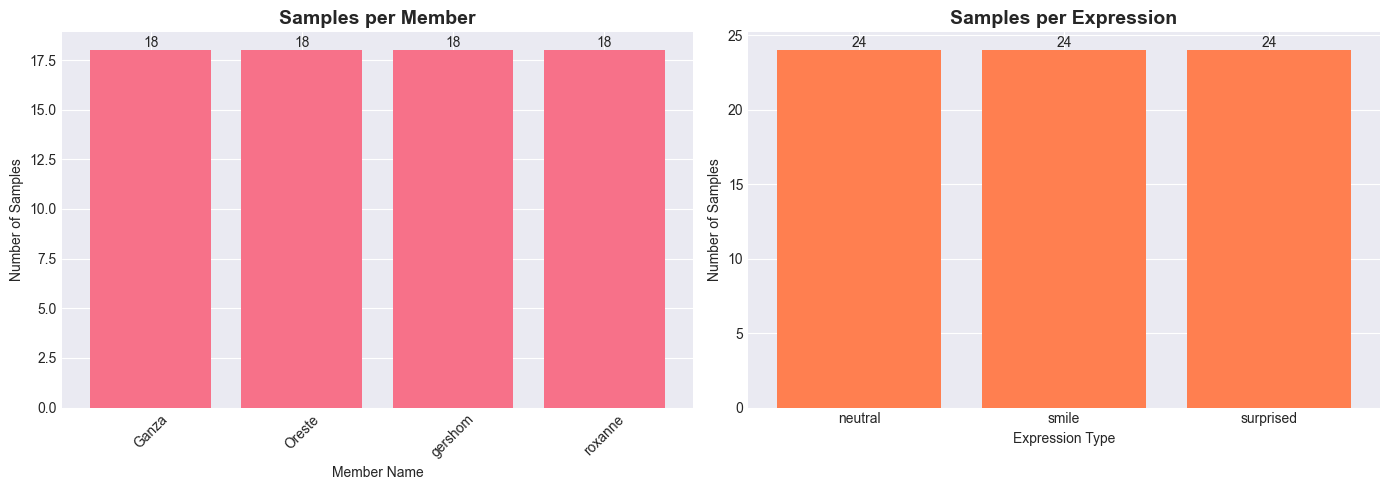

In [4]:
# Visualize member distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Member distribution
member_counts = df['member_name'].value_counts()
axes[0].bar(member_counts.index, member_counts.values)
axes[0].set_title('Samples per Member', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Member Name')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(member_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Expression distribution
expr_counts = df['expression'].value_counts()
axes[1].bar(expr_counts.index, expr_counts.values, color='coral')
axes[1].set_title('Samples per Expression', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Expression Type')
axes[1].set_ylabel('Number of Samples')
for i, v in enumerate(expr_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 2. Prepare Features and Labels

We need to:
1. Encode member names as numeric labels
2. Separate feature columns from metadata columns
3. Handle any missing values
4. Split the data into training and validation sets


In [5]:
# Encode member names as labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["member_name"])

print("Label mapping:")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {name} -> {i}")

# Select feature columns (exclude metadata columns)
exclude_cols = {"member_name", "expression", "augmentation", "image_path", "label"}
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal feature columns: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")
print(f"Last 10 features: {feature_cols[-10:]}")


Label mapping:
  Ganza -> 0
  Oreste -> 1
  gershom -> 2
  roxanne -> 3

Total feature columns: 276
First 10 features: ['hist_0', 'hist_1', 'hist_2', 'hist_3', 'hist_4', 'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9']
Last 10 features: ['color_moment_1', 'color_moment_2', 'color_moment_3', 'color_moment_4', 'color_moment_5', 'color_moment_6', 'color_moment_7', 'color_moment_8', 'mean_intensity', 'std_intensity']


In [6]:
# Extract features and labels
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Handle NaN values
if np.isnan(X).any():
    print("\nWarning: NaN values found. Filling with 0.")
    X = np.nan_to_num(X)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Features per sample: {X_train.shape[1]}")


Feature matrix shape: (72, 276)
Label vector shape: (72,)

Training set: 54 samples
Validation set: 18 samples
Features per sample: 276


## 3. Train Models

We'll train two classifiers:
1. **Random Forest**: Ensemble method using multiple decision trees
2. **Logistic Regression**: Linear classifier with regularization

After training both, we'll compare their performance and select the best one.


In [7]:
# Train Random Forest Classifier
print("="*60)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)
print("Random Forest training complete!")


TRAINING RANDOM FOREST CLASSIFIER
Random Forest training complete!


In [8]:
# Evaluate Random Forest
rf_pred = rf_model.predict(X_val)
rf_acc = accuracy_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred, average='weighted')

print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Validation Accuracy: {rf_acc:.2%}")
print(f"Validation F1-Score (weighted): {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_pred, target_names=label_encoder.classes_))


RANDOM FOREST RESULTS
Validation Accuracy: 100.00%
Validation F1-Score (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

       Ganza       1.00      1.00      1.00         5
      Oreste       1.00      1.00      1.00         4
     gershom       1.00      1.00      1.00         5
     roxanne       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [9]:
# Train Logistic Regression Classifier
print("="*60)
print("TRAINING LOGISTIC REGRESSION CLASSIFIER")
print("="*60)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight="balanced",
    solver='lbfgs'
)

lr_model.fit(X_train, y_train)
print("Logistic Regression training complete!")


TRAINING LOGISTIC REGRESSION CLASSIFIER
Logistic Regression training complete!


In [10]:
# Evaluate Logistic Regression
lr_pred = lr_model.predict(X_val)
lr_acc = accuracy_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred, average='weighted')

print("="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Validation Accuracy: {lr_acc:.2%}")
print(f"Validation F1-Score (weighted): {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_pred, target_names=label_encoder.classes_))


LOGISTIC REGRESSION RESULTS
Validation Accuracy: 77.78%
Validation F1-Score (weighted): 0.7721

Classification Report:
              precision    recall  f1-score   support

       Ganza       0.67      0.80      0.73         5
      Oreste       1.00      0.50      0.67         4
     gershom       0.71      1.00      0.83         5
     roxanne       1.00      0.75      0.86         4

    accuracy                           0.78        18
   macro avg       0.85      0.76      0.77        18
weighted avg       0.83      0.78      0.77        18



## 4. Model Comparison and Visualization

Let's compare the performance of both models and visualize the results.


In [11]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_acc, lr_acc],
    'F1-Score': [rf_f1, lr_f1]
})

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))

# Select best model
if rf_acc >= lr_acc:
    best_model = rf_model
    best_name = "Random Forest"
    best_acc = rf_acc
    best_f1 = rf_f1
else:
    best_model = lr_model
    best_name = "Logistic Regression"
    best_acc = lr_acc
    best_f1 = lr_f1

print(f"\n{'='*60}")
print(f"Selected Model: {best_name}")
print(f"Final Accuracy: {best_acc:.2%}")
print(f"Final F1-Score: {best_f1:.4f}")
print("="*60)


MODEL COMPARISON
              Model  Accuracy  F1-Score
      Random Forest  1.000000  1.000000
Logistic Regression  0.777778  0.772126

Selected Model: Random Forest
Final Accuracy: 100.00%
Final F1-Score: 1.0000


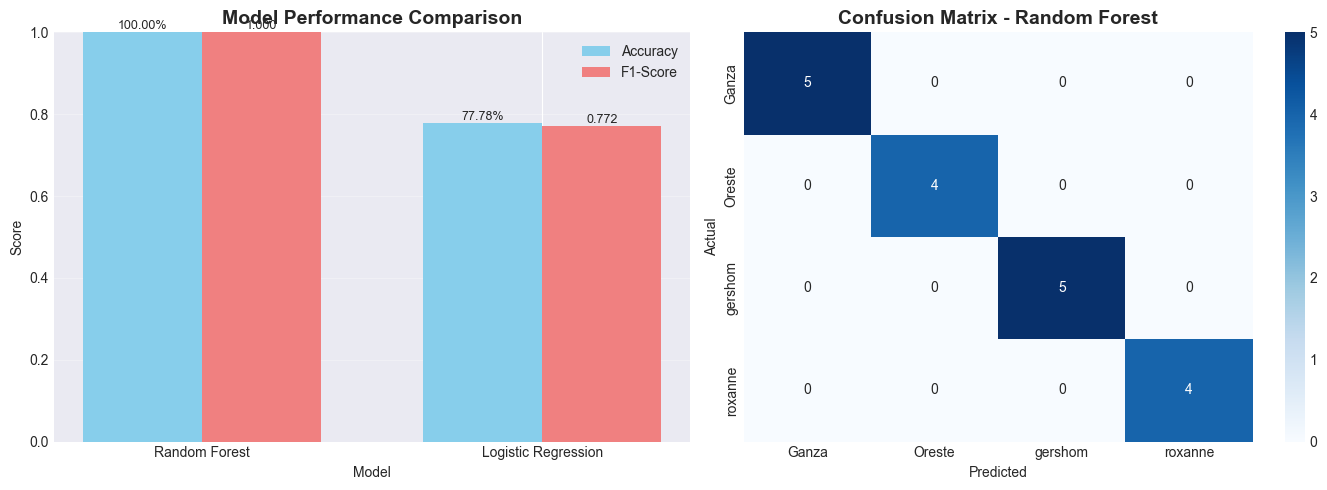

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(comparison))
width = 0.35

# Accuracy comparison
axes[0].bar(x_pos - width/2, comparison['Accuracy'], width, label='Accuracy', color='skyblue')
axes[0].bar(x_pos + width/2, comparison['F1-Score'], width, label='F1-Score', color='lightcoral')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add value labels
for i, (acc, f1) in enumerate(zip(comparison['Accuracy'], comparison['F1-Score'])):
    axes[0].text(i - width/2, acc, f'{acc:.2%}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, f1, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion matrix for best model
best_pred = rf_pred if best_model == rf_model else lr_pred
cm = confusion_matrix(y_val, best_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Save the Best Model

Save the trained model, label encoder, and feature columns for later use in face verification.


In [13]:
# Save the best model and dependencies
model_dir = Path("../trained-models/models")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, model_dir / "face_recognition_model.pkl")
joblib.dump(label_encoder, model_dir / "face_label_encoder.pkl")
joblib.dump(feature_cols, model_dir / "face_feature_columns.pkl")

print("="*60)
print("MODEL SAVED SUCCESSFULLY")
print("="*60)
print(f"   -> {model_dir / 'face_recognition_model.pkl'}")
print(f"   -> {model_dir / 'face_label_encoder.pkl'}")
print(f"   -> {model_dir / 'face_feature_columns.pkl'}")
print(f"\nSelected model: {best_name}")
print(f"Final Accuracy: {best_acc:.2%}")
print(f"Final F1-Score: {best_f1:.4f}")
print("="*60)


MODEL SAVED SUCCESSFULLY
   -> ../trained-models/models/face_recognition_model.pkl
   -> ../trained-models/models/face_label_encoder.pkl
   -> ../trained-models/models/face_feature_columns.pkl

Selected model: Random Forest
Final Accuracy: 100.00%
Final F1-Score: 1.0000


## 6. Face Verification

Now let's test the trained model on new images to verify faces. This demonstrates how the model can be used in practice for authentication.


In [14]:
# Define face verification function
def verify_face_image(image_path, model, label_encoder, feature_cols, processor, threshold=0.6):
    """
    Verify if a face image matches any of the registered members.
    
    Parameters:
    -----------
    image_path : str or Path
        Path to the image file to verify
    model : sklearn model
        Trained facial recognition model
    label_encoder : LabelEncoder
        Encoder for member names
    feature_cols : list
        List of feature column names
    processor : ImageProcessor
        Image processor for feature extraction
    threshold : float
        Minimum probability threshold for acceptance (default: 0.6)
    
    Returns:
    --------
    recognized_member : str or None
        Name of recognized member, or None if not recognized
    confidence : float
        Confidence score (probability) of the recognition
    is_authorized : bool
        True if recognized with confidence above threshold
    probabilities : dict
        Dictionary of probabilities for all members
    """
    # Load and process image
    try:
        img = processor.load_image(image_path)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, 0.0, False, {}
    
    # Extract features (same as training)
    hist_features = processor.extract_histogram_features(img)
    hog_features = processor.extract_hog_features(img)
    lbp_features = processor.extract_lbp_features(img)
    color_moments = processor.extract_color_moments(img)
    
    # Create feature dictionary
    feature_dict = {
        'mean_intensity': np.mean(img),
        'std_intensity': np.std(img)
    }
    
    # Add histogram features (reduced for CSV - same as training)
    hist_reduced = hist_features[::10]
    for i, val in enumerate(hist_reduced):
        feature_dict[f'hist_{i}'] = val
    
    # Add HOG features (reduced)
    hog_reduced = hog_features[::50]
    for i, val in enumerate(hog_reduced):
        feature_dict[f'hog_{i}'] = val
    
    # Add LBP features (reduced)
    lbp_reduced = lbp_features[::10]
    for i, val in enumerate(lbp_reduced):
        feature_dict[f'lbp_{i}'] = val
    
    # Add color moments
    for i, val in enumerate(color_moments):
        feature_dict[f'color_moment_{i}'] = val
    
    # Convert to DataFrame
    df_test = pd.DataFrame([feature_dict])
    
    # Ensure all feature columns are present
    for col in feature_cols:
        if col not in df_test.columns:
            df_test[col] = 0.0
    
    X_test = df_test[feature_cols].values.astype(np.float32)
    
    # Handle NaN values
    if np.isnan(X_test).any():
        X_test = np.nan_to_num(X_test)
    
    # Predict probabilities
    proba = model.predict_proba(X_test)[0]
    idx = proba.argmax()
    recognized_member = label_encoder.classes_[idx]
    confidence = proba[idx]
    
    # Create probabilities dictionary
    probabilities = {label_encoder.classes_[i]: proba[i] for i in range(len(label_encoder.classes_))}
    
    # Check if above threshold
    is_authorized = confidence >= threshold
    
    return recognized_member, confidence, is_authorized, probabilities

print("Face verification function defined!")


Face verification function defined!


In [15]:
# Load image processor
processor = ImageProcessor(base_dir='../Images')

# Test on a sample image (use one of your team member images)
test_images_dir = Path("../Images")

# Find available test images
test_images = []
for member_name in label_encoder.classes_:
    for ext in ['.jpg', '.jpeg', '.png']:
        img_path = test_images_dir / f"{member_name}_neutral{ext}"
        if img_path.exists():
            test_images.append(img_path)
            break

if not test_images:
    print("No test images found. Please add images to the Images directory.")
else:
    print(f"Found {len(test_images)} test images:")
    for img in test_images:
        print(f"  - {img.name}")


Found 4 test images:
  - Ganza_neutral.jpg
  - Oreste_neutral.jpg
  - gershom_neutral.jpg
  - roxanne_neutral.jpg


In [16]:
# Verify faces on test images
if test_images:
    print("="*60)
    print("FACE VERIFICATION RESULTS")
    print("="*60)
    
    threshold = 0.6
    
    for img_path in test_images[:4]:  # Test up to 4 images
        print(f"\nTesting: {img_path.name}")
        print("-" * 60)
        
        member, confidence, authorized, probabilities = verify_face_image(
            img_path, best_model, label_encoder, feature_cols, processor, threshold
        )
        
        if authorized:
            print(f"✓ ACCESS GRANTED")
            print(f"  Recognized as: {member}")
            print(f"  Confidence: {confidence:.2%}")
        else:
            print(f"✗ ACCESS DENIED")
            print(f"  Best match: {member} (confidence: {confidence:.2%})")
            print(f"  Confidence below threshold ({threshold:.1%})")
        
        print(f"\n  All probabilities:")
        for name, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"    {name}: {prob:.2%}")


FACE VERIFICATION RESULTS

Testing: Ganza_neutral.jpg
------------------------------------------------------------
✓ ACCESS GRANTED
  Recognized as: Ganza
  Confidence: 99.20%

  All probabilities:
    Ganza: 99.20%
    Oreste: 0.40%
    gershom: 0.20%
    roxanne: 0.20%

Testing: Oreste_neutral.jpg
------------------------------------------------------------
✓ ACCESS GRANTED
  Recognized as: Oreste
  Confidence: 96.80%

  All probabilities:
    Oreste: 96.80%
    roxanne: 2.20%
    gershom: 0.80%
    Ganza: 0.20%

Testing: gershom_neutral.jpg
------------------------------------------------------------
✓ ACCESS GRANTED
  Recognized as: gershom
  Confidence: 97.40%

  All probabilities:
    gershom: 97.40%
    Oreste: 1.20%
    roxanne: 0.80%
    Ganza: 0.60%

Testing: roxanne_neutral.jpg
------------------------------------------------------------
✓ ACCESS GRANTED
  Recognized as: roxanne
  Confidence: 99.40%

  All probabilities:
    roxanne: 99.40%
    Ganza: 0.60%
    Oreste: 0.00%

## 7. Visualize Verification Results

Let's create visualizations showing the verification probabilities for test images.


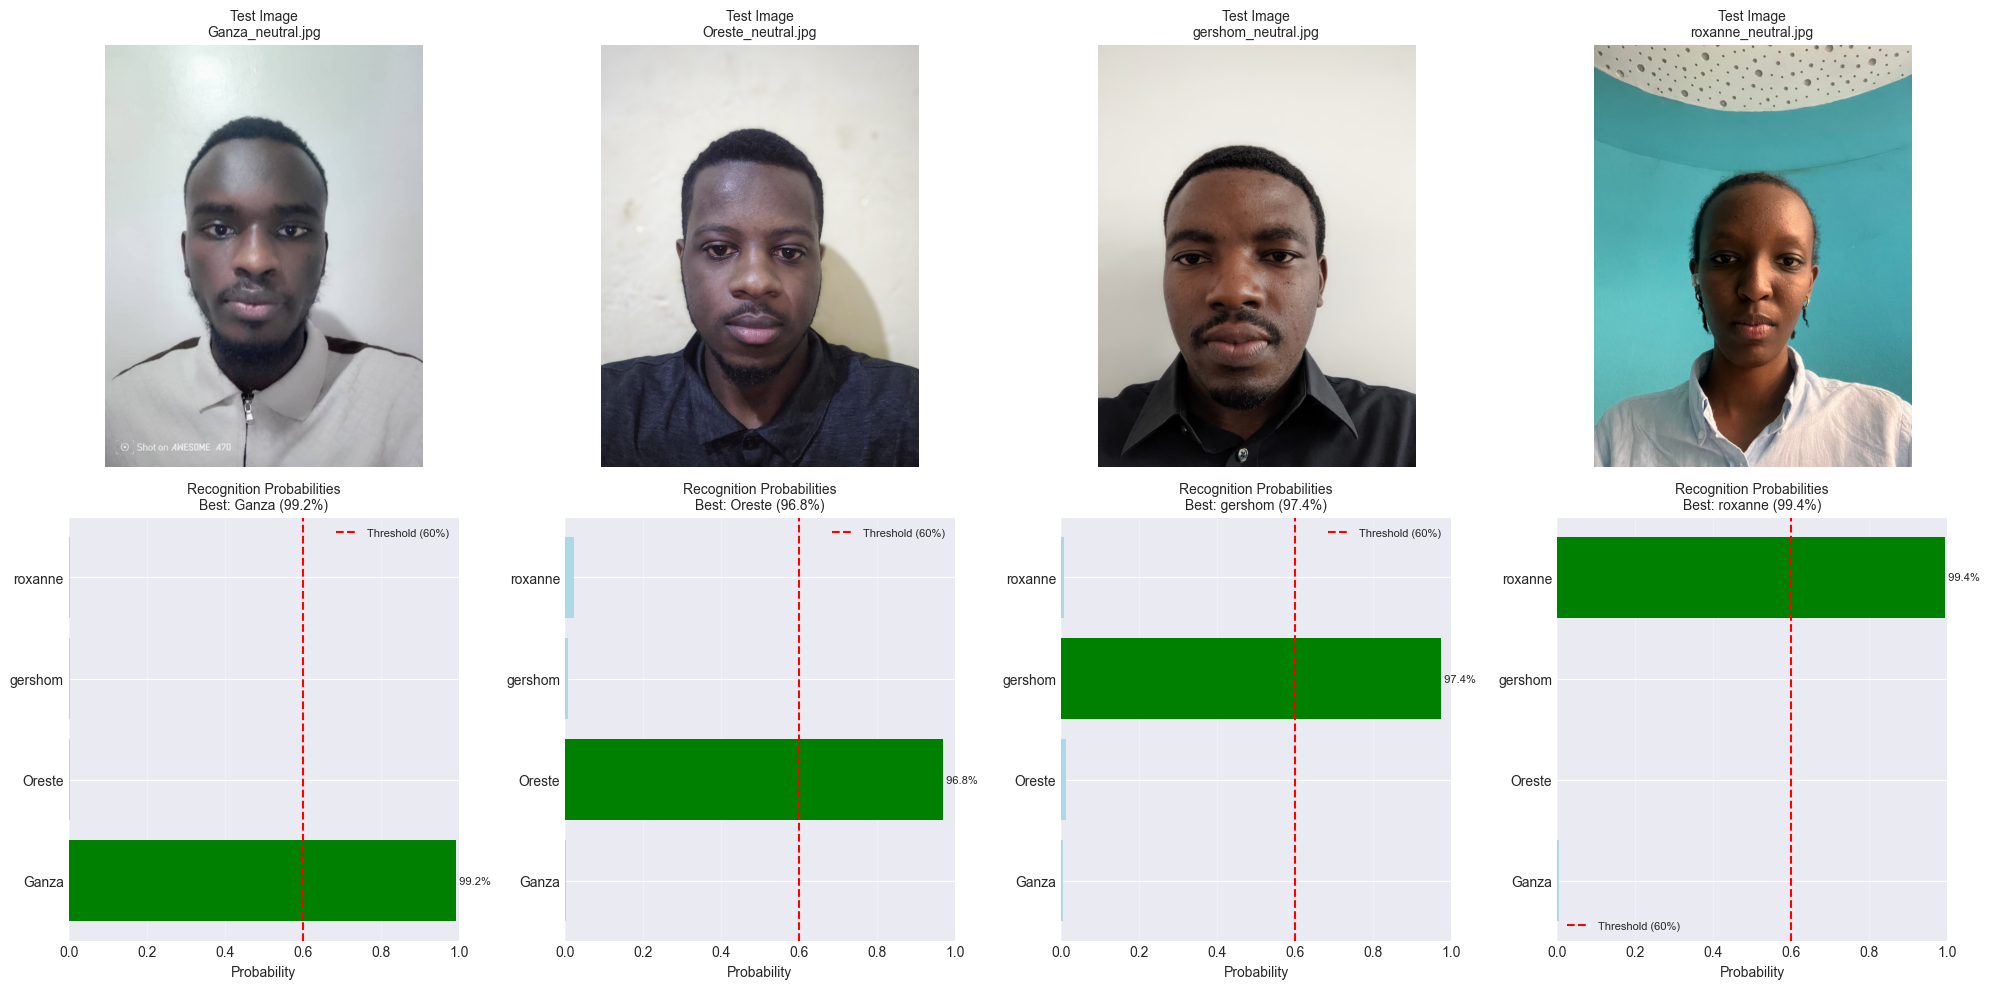

In [17]:
# Visualize verification results
if test_images:
    n_images = min(4, len(test_images))
    fig, axes = plt.subplots(2, n_images, figsize=(5*n_images, 10))
    
    if n_images == 1:
        axes = axes.reshape(-1, 1)
    
    threshold = 0.6
    
    for idx, img_path in enumerate(test_images[:n_images]):
        # Load and display image
        img = processor.load_image(img_path)
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f"Test Image\n{img_path.name}", fontsize=10)
        axes[0, idx].axis('off')
        
        # Get verification results
        member, confidence, authorized, probabilities = verify_face_image(
            img_path, best_model, label_encoder, feature_cols, processor, threshold
        )
        
        # Plot probabilities
        names = list(probabilities.keys())
        probs = [probabilities[name] for name in names]
        
        colors = ['green' if name == member else 'lightblue' for name in names]
        if authorized:
            colors = ['green' if name == member and probs[i] >= threshold else 'lightblue' 
                     for i, name in enumerate(names)]
        
        bars = axes[1, idx].barh(names, probs, color=colors)
        axes[1, idx].axvline(x=threshold, color='red', linestyle='--', 
                            label=f'Threshold ({threshold:.0%})')
        axes[1, idx].set_xlabel('Probability')
        axes[1, idx].set_title(f'Recognition Probabilities\nBest: {member} ({confidence:.1%})', 
                              fontsize=10)
        axes[1, idx].set_xlim([0, 1])
        axes[1, idx].legend(fontsize=8)
        axes[1, idx].grid(axis='x', alpha=0.3)
        
        # Add probability labels on bars
        for i, (name, prob) in enumerate(zip(names, probs)):
            if prob > 0.05:  # Only show labels for probabilities > 5%
                axes[1, idx].text(prob, i, f' {prob:.1%}', 
                                 va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
